<a href="https://colab.research.google.com/github/Mburu-Elvis/mnist_fashion-classificaton/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-trained models


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


## Building and Deploying an Apparel Classifier

We'll be using the in-built Fashion MNIST dataset
It hass 60,000 training set and 10,000 test set


It has 10 label/classes.

We want to classify clothing in accordance to its class

## Loading the dataset

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Skirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {} of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {} of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28) of uint8
Test_images.shape: (10000, 28, 28) of uint8


## Training a simple CNN

### Reshaping the Image data for Modelling

In [4]:
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)


print('Train_images.shape: {} of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {} of {}'.format(test_images_gr.shape, test_images_gr.dtype))

Train_images.shape: (60000, 28, 28, 1) of uint8
Test_images.shape: (10000, 28, 28, 1) of uint8


## Visualize some images

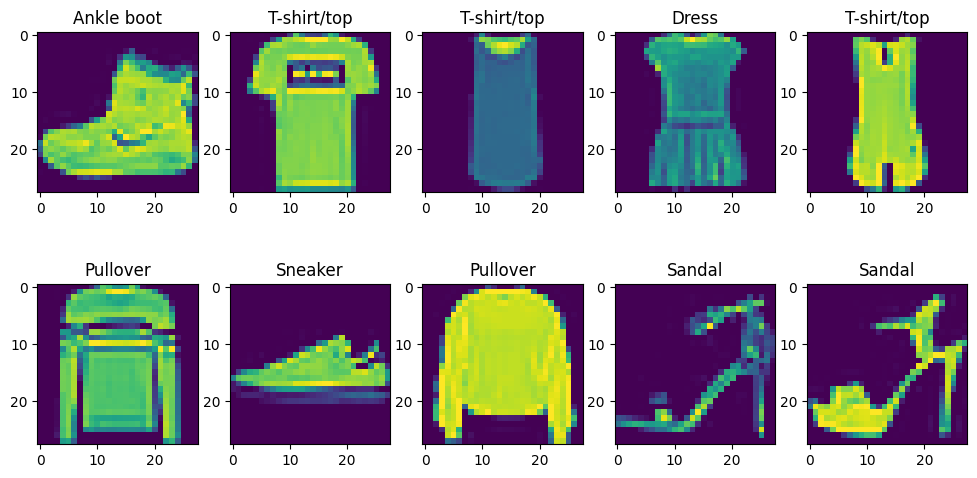

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(12,6))
c = 0
for i in range(10):
  idx = i // 5
  idy = i % 5
  ax[idx, idy].imshow(train_images_gr[i].reshape(28, 28))
  ax[idx, idy].set_title(class_names[train_labels[i]])


## Build a CNN Architecture

In [6]:
from ast import In
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.Sequential()

# define conv-pool layers set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1),
                                 activation='relu', padding='valid', input_shape = INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                          activation='relu', padding='valid', input_shape = INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add outplut layer
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# viem model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

## Model Training

In [7]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2,
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=es_callback,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 42s 24ms/step - loss: 0.5419 - accuracy: 0.8011 - val_loss: 0.3588 - val_accuracy: 0.8677
Epoch 2/100
1688/1688 [==============================] - 41s 24ms/step - loss: 0.3527 - accuracy: 0.8715 - val_loss: 0.3338 - val_accuracy: 0.8765
Epoch 3/100
1688/1688 [==============================] - 44s 26ms/step - loss: 0.3051 - accuracy: 0.8879 - val_loss: 0.2774 - val_accuracy: 0.8960
Epoch 4/100
1688/1688 [==============================] - 41s 24ms/step - loss: 0.2773 - accuracy: 0.8964 - val_loss: 0.2568 - val_accuracy: 0.9062
Epoch 5/100
1688/1688 [==============================] - 41s 24ms/step - loss: 0.2543 - accuracy: 0.9063 - val_loss: 0.2814 - val_accuracy: 0.8978
Epoch 6/100
1688/1688 [==============================] - 41s 24ms/step - loss: 0.2345 - accuracy: 0.9135 - val_loss: 0.2644 - val_accuracy: 0.9003
Epoch 6: early stopping


## Plotting Learning Curves

<Axes: >

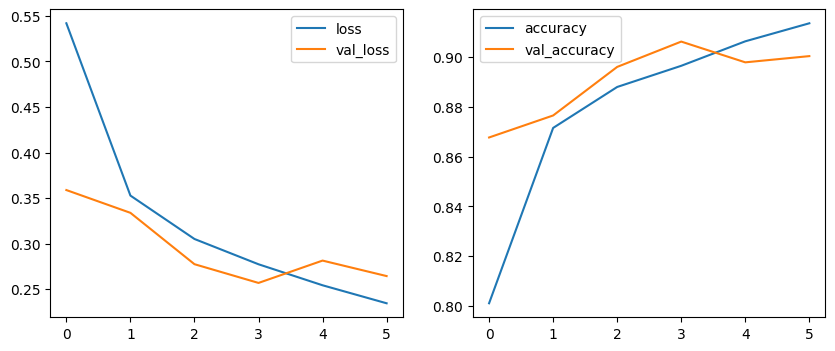

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])

## Evaluate Model Performance

In [9]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

313/313 [==============================] - 2s 7ms/step


array([[1.4885818e-07, 1.3488574e-07, 2.3901714e-07, 6.8112831e-07,
        3.7676904e-07, 1.0389910e-04, 5.1118622e-07, 3.0527408e-03,
        4.0367487e-07, 9.9684089e-01],
       [8.1107835e-08, 4.3676673e-12, 9.9995583e-01, 1.1581421e-09,
        6.5239883e-06, 3.7323914e-14, 3.7493333e-05, 5.8868100e-15,
        8.5283132e-09, 8.9401631e-14],
       [7.3086761e-17, 9.9999994e-01, 1.5019330e-16, 3.7655616e-15,
        5.2010147e-14, 2.3509713e-21, 8.0256366e-16, 1.7388604e-23,
        3.5326625e-20, 2.3991332e-21],
       [3.4593466e-14, 9.9999994e-01, 6.9794404e-14, 3.7450537e-12,
        1.2905197e-11, 1.8545750e-17, 3.3528640e-13, 2.0317208e-19,
        2.0137059e-17, 2.4666135e-17],
       [1.8772273e-01, 1.5982491e-04, 1.2656653e-01, 4.6295966e-03,
        5.8791256e-03, 8.0743475e-06, 6.7444378e-01, 6.5869079e-07,
        5.8381737e-04, 5.8971368e-06]], dtype=float32)

In [10]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.79      0.90      0.84      1000
       Dress       0.92      0.89      0.90      1000
        Coat       0.83      0.84      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Skirt       0.76      0.67      0.71      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Skirt,Sneaker,Bag,Ankle boot
T-shirt/top,857,1,32,13,5,1,86,0,5,0
Trouser,1,981,0,13,3,0,0,0,2,0
Pullover,8,1,896,10,42,0,41,0,2,0
Dress,19,8,13,886,39,0,33,0,2,0
Coat,1,1,80,23,844,0,50,0,1,0
Sandal,0,0,0,0,0,970,1,18,0,11
Skirt,120,1,104,18,77,0,667,0,13,0
Sneaker,0,0,0,0,0,8,0,958,0,34
Bag,3,1,4,1,2,2,3,5,977,2
Ankle boot,0,0,0,0,0,3,1,23,0,973


In [13]:
model.save("model.hdf5")